In [77]:
df=pd.read_excel('dataset_for_cate.xlsx')

In [233]:
df.sample(5)

,ID,T,bus_offers_count,passenger_count,direction_conv,price_mean,price_min,price_max,price_std,final_rating_mean,...,avia_pages,train,etrain,bus_pages,tours,avia_orders,bus_orders,zhd,buy,total_profit
65694,79544,1,8,1,0.032283,1184.100908,1122.00000,1578.801210,219.107457,8.932008,...,0,0,0,0,0,0,0,0,0,0.000000
13198,15961,1,2,4,0.058468,2026.768130,2026.76813,2702.357507,989.949494,8.141022,...,0,0,0,0,0,0,0,0,0,0.000000
46163,55807,1,6,1,0.104803,1345.000000,1200.00000,1670.000000,186.949191,8.679214,...,0,0,0,0,0,0,0,0,1,80.094915
61840,74808,1,32,1,0.218007,271.088862,250.00000,323.000000,13.421779,8.001372,...,0,0,0,0,0,0,0,0,0,0.000000
1424,1714,1,1,1,0.013538,2375.000000,2375.00000,2375.000000,0.000000,7.908729,...,0,37,9,2,0,0,0,1,0,0.000000


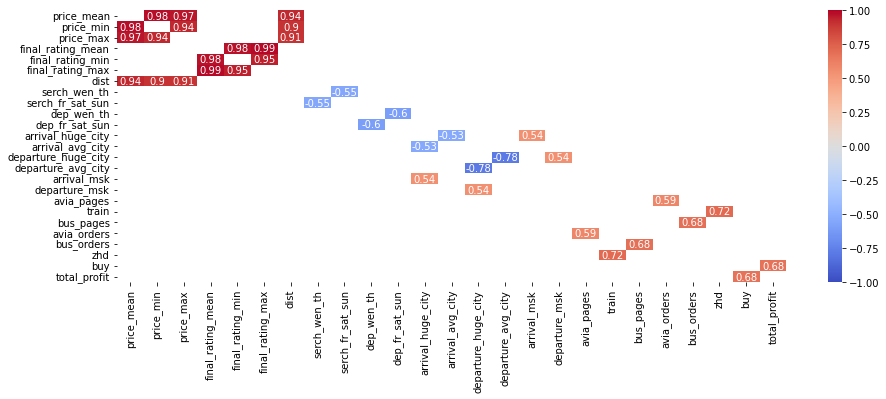

In [191]:
#считаю матрицу корреляции, для удобства отображения подсвечиваю только тот уровень корреляции,
#который больше 0,5 по модулю
import matplotlib.pyplot as plt

dfCorr = df.drop(['ID'], axis=1).corr()
filteredDf = dfCorr[((dfCorr >= .5) | (dfCorr <= -.5)) & (dfCorr !=1.000)]
for column in filteredDf.columns:
    if filteredDf[column].isna().sum() == len(filteredDf):
        filteredDf=filteredDf.drop(column, axis=1)
        filteredDf=filteredDf.drop(column)
plt.figure(figsize=(15,5))
#matrix = np.triu(filteredDf.corr())
sns.heatmap(filteredDf, annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')
plt.show()

In [229]:
#рассчитываю vif для проверки мультиколлениарности
from statsmodels.stats.outliers_influence import variance_inflation_factor

X=['T', 'bus_offers_count', 'passenger_count', 'direction_conv',
       'price_mean', 'price_min', 'price_max', 'price_std',
       'final_rating_mean', 'final_rating_min', 'final_rating_max',
       'final_rating_std', 'dist', 'depth', 'global_source_direct',
       'global_source_marketing', 'bus_entry', 'serch_wen_th',
       'serch_fr_sat_sun', 'dep_wen_th', 'dep_fr_sat_sun', 'arrival_huge_city',
       'arrival_avg_city', 'departure_huge_city', 'departure_avg_city',
       'arrival_msk', 'departure_msk', 'arrival_spb', 'departure_spb',
       'avia_pages', 'train', 'etrain', 'bus_pages', 'tours', 'avia_orders',
       'bus_orders', 'zhd'] 

def vif (data, X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
    return(pd.DataFrame(vif_data))


vif=vif(df, df[X])
vif=vif[vif['VIF'] > 10].round(3)
vif

,feature,VIF
4,price_mean,283.028
5,price_min,125.601
6,price_max,65.615
8,final_rating_mean,1398.219
9,final_rating_min,392.789
10,final_rating_max,1383.856
11,final_rating_std,13.031
12,dist,26.198


In [232]:
import numpy as np
from econml.dml import CausalForestDML
y=['buy']
X=['bus_offers_count', 'passenger_count', 'direction_conv',
       'price_mean', 'price_min', 'price_max', 'price_std',
       'final_rating_mean', 'final_rating_min', 'final_rating_max',
       'final_rating_std', 'dist', 'depth', 'global_source_direct',
       'global_source_marketing', 'bus_entry', 'serch_wen_th',
       'serch_fr_sat_sun', 'dep_wen_th', 'dep_fr_sat_sun', 'arrival_huge_city',
       'arrival_avg_city', 'departure_huge_city', 'departure_avg_city',
       'arrival_msk', 'departure_msk', 'arrival_spb', 'departure_spb',
       'avia_pages', 'train', 'etrain', 'bus_pages', 'tours', 'avia_orders',
       'bus_orders', 'zhd'] 
X=df[X]
Y=np.ravel(df[y])
T = df['T']
W=None

causal_forest_buy = CausalForestDML(criterion='het', n_estimators=5000,       
                      min_samples_leaf=100, 
                      max_depth=4, cv=10,min_samples_split=50, honest=True)
                      
# fit train data to causal forest model 
causal_forest_buy.fit(Y, T, X=X, W=W, cache_values=True)
# estimate the CATE with the test set 
causal_forest_buy.const_marginal_ate(X)

In [239]:
causal_forest_buy.const_marginal_effect(X).mean()

In [234]:
causal_forest_buy.const_marginal_ate_inference(X)

 99%|===================| 3951/4000 [00:50<00:00]        

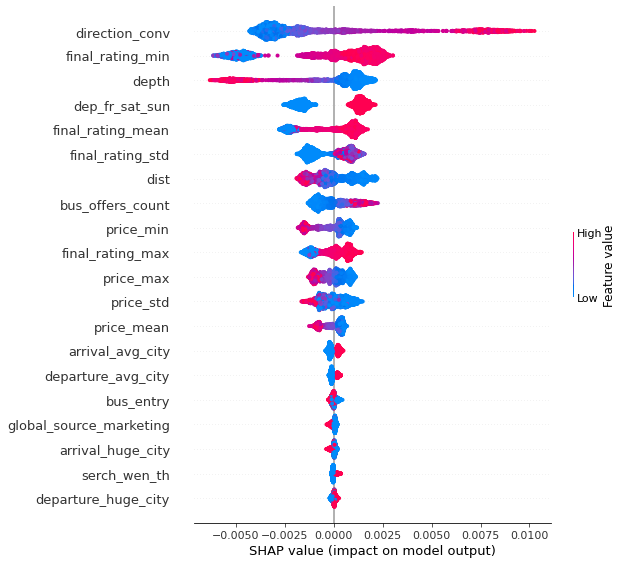

In [207]:
import shap

# calculate shap values of causal forest model 
shap_values = causal_forest_buy.shap_values(X)
# plot shap values 
shap.summary_plot(shap_values['Y0']['T'])

In [209]:
treatment_effects = causal_forest_buy.const_marginal_effect(X)
te_lower, te_upper = causal_forest_buy.const_marginal_effect_interval(X)
res = causal_forest_buy.const_marginal_effect_inference(X)
res.summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,-0.005,0.013,-0.411,0.681,-0.030,0.020
1,0.002,0.011,0.211,0.833,-0.018,0.023
2,0.018,0.011,1.697,0.090,-0.003,0.038
3,-0.007,0.008,-0.915,0.360,-0.023,0.008
4,0.018,0.018,1.016,0.310,-0.017,0.053
...,...,...,...,...,...,...
3995,0.015,0.020,0.778,0.437,-0.023,0.054
3996,0.017,0.011,1.579,0.114,-0.004,0.039
3997,0.011,0.007,1.623,0.105,-0.002,0.024


In [215]:
features=[]
features=np.array(list(zip(causal_forest_buy.cate_feature_names(), causal_forest_buy.feature_importances_.tolist())))
features=pd.DataFrame(features).rename(columns={0: 'covariate', 1: 'importance'}).round(3)
features_table=features.sort_values(by='importance', ascending=False).head(5)

In [235]:
features_table

,covariate,importance
2,direction_conv,0.2180034361551372
8,final_rating_min,0.11708563382795424
12,depth,0.09646052916018359
7,final_rating_mean,0.07882444410895743
6,price_std,0.05719363708452825
